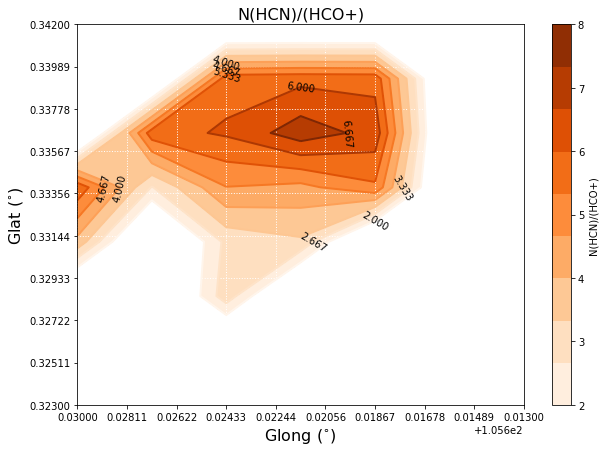

In [2]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import math as m 
import os
import sys
import re

from astropy.utils import data
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

# Set path to your home directory
path='/Users/jane/Desktop' 

### Plotting column density ratio maps ###

# import HCN and HCO+ col. den. data files

# "A" denotes the first molecule (here HCO+)
A = pd.read_csv(path+'/'+'columnDenHCO+.txt', sep="\t", header=None)
dataA = pd.DataFrame(data=A)

# create lists for coordinates and column density (omitting the first row/header)
xPixA = np.array(dataA[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(dataA[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(dataA[2].tolist())
glatA = glatA[1:]
glongA = np.array(dataA[3].tolist())
glongA = glongA[1:]
nA = np.array(dataA[8].tolist())
nA = nA[1:]
nAfloat = nA.astype(float) # float needed later on

# "B" denotes the second molecule (usually HCN)
B = pd.read_csv(path+'/'+'columnDenHCN.txt', sep="\t", header=None)
dataB = pd.DataFrame(data=B)

xPixB = np.array(dataB[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(dataB[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(dataB[2].tolist())
glatB = glatB[1:]
glongB = np.array(dataB[3].tolist())
glongB = glongB[1:]
nB = np.array(dataB[8].tolist())
nB = nB[1:]
nBfloat = nB.astype(float) # float needed later on

# convert round glat, glong to arrays of floats and round to 4 decimals to be compared in following for loop
glatA = np.round(glatA.astype(float), 3)
glatB = np.round(glatB.astype(float), 3)
glongA = np.round(glongA.astype(float), 3)
glongB = np.round(glongB.astype(float), 3)

# ensure glat,glong coordinates match xPix, yPix between molecules
for i in range(len(xPixA)):
    for j in range(len(xPixB)):
        if ((xPixA[i] == xPixB[j]) and (yPixA[i] == yPixB[j])):
            if ((glatA[i] != glatB[j]) or (glongA[i] != glongB[j])):
                print('Error- molecule coordinates not alligned')

# If no errors, use coordinates from either molecule for both (here HCO+ is used)

# Eliminating doubles from coordinate lists
# Loop searches for coordinate pair and appends if it is not already in the list

def shorten(listLong):
    x = len(listLong)
    temp = []
    for i in range(x):
        if (listLong[i] not in temp):
            temp.append(listLong[i])
            temp.sort() # reorders list from smallest to largest
    return(temp)

glatAshort = shorten(glatA)
glatBshort = shorten(glatB)
glongAshort = shorten(glongA)
glongBshort = shorten(glongB)

# <= for smaller array range, >= for larger array range
# regardless of range choice, density ratio will only populate areas both ranges cover
# here HCO+ has larger range

if (len(glatAshort) >= len(glatBshort)):
    lenglat = len(glatAshort)
    savedglat = glatAshort
else:
    lenglat = len(glatBshort)
    savedglat = glatBshort

if (len(glongAshort) >= len(glongBshort)):
    lenglong = len(glongAshort)
    savedglong = glongAshort
else:
    lenglong = len(glongBshort)
    savedglong = glongBshort
    
largeArray = np.zeros([lenglat,lenglong]) # array of desired size of zeros for largest span of coordinates

largeCoord = []
for i in range(len(savedglat)):
    for j in range(len(savedglong)):
        largeCoord.append([savedglat[i], savedglong[j]])
#largeCoord = largeCoord[::-1]        

# ratio of column density will be found for pixels that contain data for both molecules

smallCoord = []
for i in range(len(glatA)):
    for j in range(len(glatB)):
        if ((glatA[i] == glatB[j]) and (glongA[i] == glongB[j])):
            ratio = (nBfloat[j]/nAfloat[i])
            lst = [[glatA[i], glongA[i]], ratio]
            smallCoord.append(lst)                     # coordinates of non-zero ratio
            
smallCoord = sorted(smallCoord, key=lambda tup: tup[0], reverse=True)            

# populating large array with dnesity ratios from small array

for i in range(len(smallCoord)):
    for j in range(len(largeCoord)):
        if (smallCoord[i][0] == largeCoord[j]):
            largeArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][1]

# finding bounds of glat and glong coordinates
# works only if list values are ascending- here they are from the shorten() function applied above
glatMin = savedglat[0]
glatMax = savedglat[-1]
glongMin = savedglong[0]
glongMax = savedglong[-1]
          
glataxis = np.asarray(savedglat, dtype='float64')
glongaxis = np.asarray(savedglong, dtype='float64')

# contour plot

u = np.linspace(glatMin, glatMax, num=len(savedglat))
v = np.linspace(glongMin, glongMax, num=len(savedglong))
breaksFill = np.linspace(2,8,10)
breaksBar = np.linspace(2,8,7)
breaksLines = np.linspace(2,8,10)
breaksLevels = np.linspace(2,8,10)
breaksy = np.linspace(glatMin, glatMax, 10)
breaksx = np.linspace(glongMin, glongMax, 10)

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, largeArray, breaksFill, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, largeArray, breaksLines, cmap='Oranges', linewidths=2) 
plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.grid(color='white', ls='dotted', lw=1)

plt.show()